# Titanic, Predicting Survivals
### Kaggle competition




TODO : 
- isAlone column : equivalent to a FamilySize of 1 ?
- investigate why SVC and KNN doesn't seem to work well

In [140]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## Data Exploration

In [141]:
train.head(6)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q


In [142]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Numerical features : 
- PassengerId
- Pclass
- Age (include missing values)
- SibSp
- Parch
- Fare
- Survived (target)

Non-numerical features :
- Name
- Sex
- Ticket
- Cabin
- Embarked

Women and children were more likely to survive, so `Age` and `Sex` will be useful. Also, `Fare` and `Pclass` are indicators of socio-economic status and will probably be useful too.

Let's check for missing values :


In [143]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [144]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

We will have to take care of those missing values in the future.

In [145]:
train['Survived'].describe()

count    891.000000
mean       0.383838
std        0.486592
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64

Approx. 38% of passengers survived.

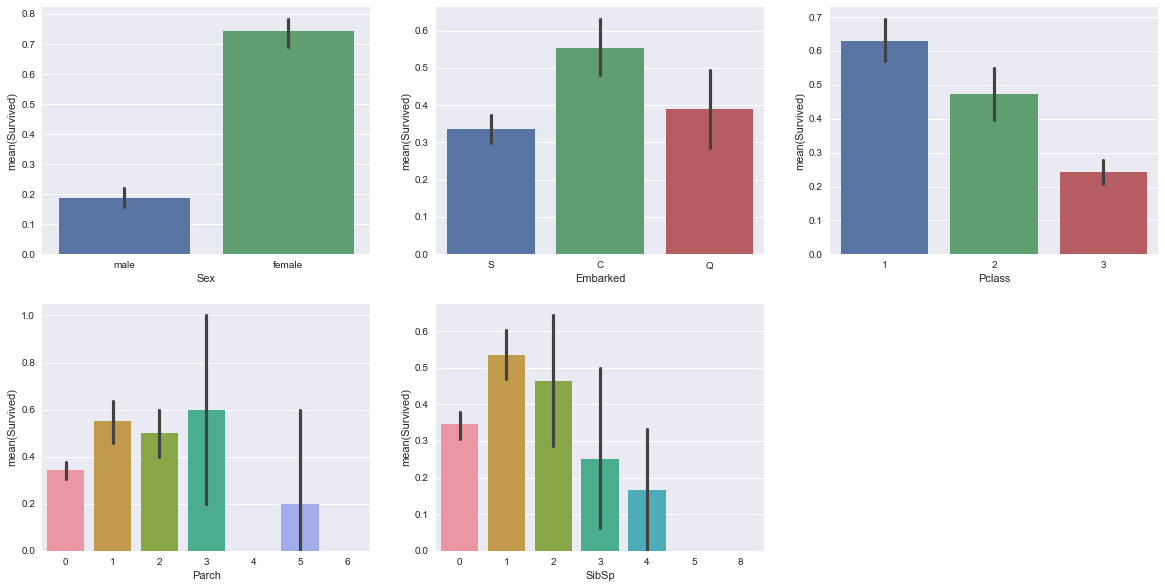

In [146]:
plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
sns.barplot(train['Sex'],train['Survived'])
plt.subplot(2,3,2)
sns.barplot(train['Embarked'],train['Survived'])
plt.subplot(2,3,3)
sns.barplot(train['Pclass'],train['Survived'])
plt.subplot(2,3,4)
sns.barplot(train['Parch'],train['Survived'])
plt.subplot(2,3,5)
sns.barplot(train['SibSp'],train['Survived'])
plt.show()

- Sex: women were way more likely to survive than men
- Embarked: people whose port of embarkation was C (Cherbourg) were also more likely to survive
- Pclass: the socio-economic class is a good indicator of survival
- Parch : being alone or having more than 4 parents/children travelling with you resulted in less chance of survival
- SibSp : similar to Parch, being alone or having 3 or more siblings/spouses gives you lowest chances of survival

Let's compare the Age and Fare distribution for both the cases where passengers survived or not:

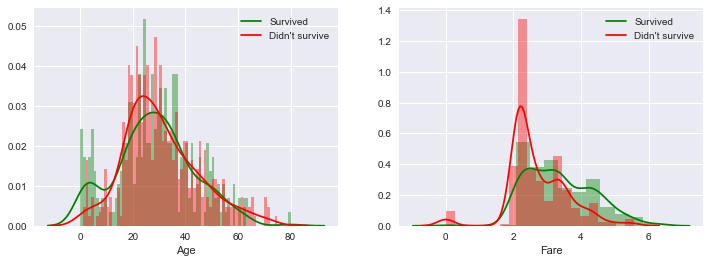

In [147]:
yes_surv = train[train['Survived'] == 1]
no_surv = train[train['Survived'] == 0]

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(yes_surv['Age'].dropna(),bins=range(0,81,1), color='g', kde_kws={"color": "g", "label": "Survived"})
sns.distplot(no_surv['Age'].dropna(),bins=range(0,81,1), color='r', kde_kws={"color": "r", "label": "Didn't survive"})
plt.subplot(1,2,2)
# we use a logarithmic scale because of the presence of outliers of the Fare column
sns.distplot(np.log(yes_surv['Fare']+1), color='g', kde_kws={"color": "g", "label": "Survived"})
sns.distplot(np.log(no_surv['Fare']+1), color='r', kde_kws={"color": "r", "label": "Didn't survive"})

plt.show()

Age:
- children younger than 10 have a higher survival rate
- there weren't many teenagers on the boat (10-16 yo)
- many young adults in the age range of approx. 18-32 didn't survive

Fare:
- cheaper tickets results in a lower chance of survival

### Other columns

The `Cabin` and `Ticket` columns does not seem to add any information immediatly accesible without a lot of feature engineering. Also, the `Cabin` column has a lot of missing values. We're not going to use these columns for modeling.

The `PassengerId` column is simply an ID column, so it does not add any information either.

## Correlation

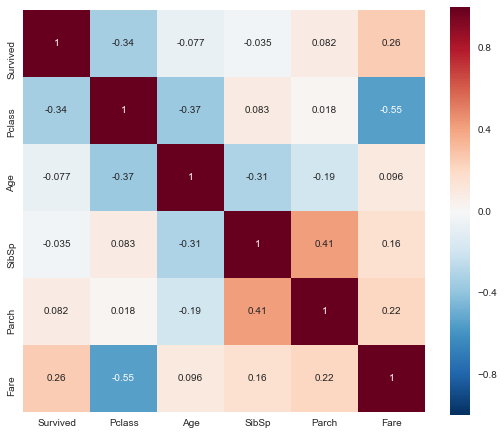

In [70]:
corr = train.drop('PassengerId', axis=1).corr()
plt.figure(figsize=(9,7.5))
sns.heatmap(corr, annot=True, square=True)
plt.show()

- `Fare` has a correlation with `Pclass`, as one could expect
- `SibSp` and `Patch` are slightly correlated, which makes sense as people travelling alone have 0 for both features, and groups of people tend to have highest score for both features

## Filling missing values
### Age
We replace the missing value of the `Age` column with the median of the train dataset (train and test have almost the same median age value).

In [71]:
med_age = train['Age'].median() #28
train['Age'].fillna(med_age, inplace=True)
test['Age'].fillna(med_age, inplace=True)

### Embarked
As the 'S' value is the most common, we're going to replace the two missing values with it.

In [72]:
train['Embarked'].fillna('S', inplace=True)

### Fare
There's only one missing value in the test dataset:

In [73]:
test[test['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


This man was from the lower-class, we're going to set his `Fare` value to the Fare median of the `Pclass` 3.

In [74]:
fare_3_med = train[train['Pclass'] == 3]['Fare'].median()
fare_3_med

8.05

In [75]:
test['Fare'].fillna(fare_3_med, inplace=True)

## Feature engineering

### NameLength
One could think the length of the name has a correlation with the Pclass, therefore indicating if the person is more likely to survive.

In [77]:
train['NameLength'] = train['Name'].apply(lambda x: len(x))
test['NameLength'] = test['Name'].apply(lambda x: len(x))

### Title
The passengers title might be a good indicator of survival.

In [78]:
len_train = len(train)

combined = pd.concat([train.drop('Survived', axis=1),test])

combined['Title'] = combined['Name'].str.split(',', expand=True)[1].str.split('.', expand=True)[0]
combined['Title'].value_counts()

 Mr              757
 Miss            260
 Mrs             197
 Master           61
 Dr                8
 Rev               8
 Col               4
 Mlle              2
 Ms                2
 Major             2
 Sir               1
 Don               1
 Mme               1
 Lady              1
 Jonkheer          1
 Dona              1
 the Countess      1
 Capt              1
Name: Title, dtype: int64

In [92]:
# this is useless as dummy coding performs way better
'''
combined.replace({'Title': {' Mr': 1,' Miss': 2,' Ms': 2,' Mrs': 3,' Master': 4,' Dr': 5,' Rev': 6,' Major': 7,' Col': 7,' Capt': 7,' Mlle': 8,' Mme': 8,' Don': 9,' Dona': 9,' Sir': 9,' Lady': 10,' the Countess': 10,' Jonkheer': 10
}}, inplace=True)
'''

"\ncombined.replace({'Title': {' Mr': 1,' Miss': 2,' Ms': 2,' Mrs': 3,' Master': 4,' Dr': 5,' Rev': 6,' Major': 7,' Col': 7,' Capt': 7,' Mlle': 8,' Mme': 8,' Don': 9,' Dona': 9,' Sir': 9,' Lady': 10,' the Countess': 10,' Jonkheer': 10\n}}, inplace=True)\n"

### Cabin_info
I make the hypothesis that if the passengers' cabin is known, there are more chances that the passenger survived.

In [80]:
combined['Cabin_info'] = combined['Cabin'].isnull() == False
combined['Cabin_info'] = combined['Cabin_info'].astype(int)

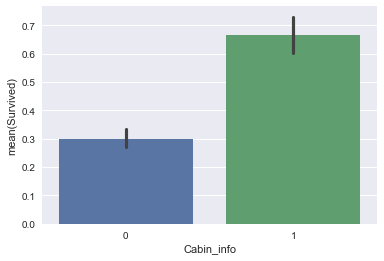

In [148]:
sns.barplot(combined.iloc[:len_train]['Cabin_info'],train['Survived'])
plt.show()

The difference is quite important so this feature might be useful.

### FamilySize

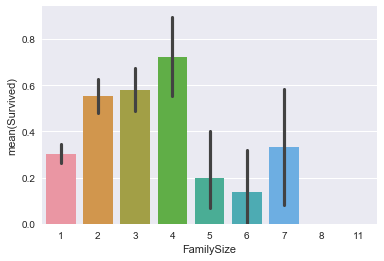

In [82]:
combined['FamilySize'] = combined['Parch'] + combined['SibSp'] + 1

sns.barplot(combined.iloc[:len_train]['FamilySize'],train['Survived'])
plt.show()

We can see that this feature adds a lot of information. For instance the fact that people travelling as a family of 4 had a way bigger chance to survive than a family of 5 (the difference between the two cases is quite surprising).

## Dummy Coding

In [83]:
dummies = pd.get_dummies(combined[['Title','Embarked','Sex']])
combined = pd.concat([combined,dummies], axis=1)

In [84]:
combined.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'NameLength', 'Title',
       'Cabin_info', 'FamilySize', 'Title_ Capt', 'Title_ Col', 'Title_ Don',
       'Title_ Dona', 'Title_ Dr', 'Title_ Jonkheer', 'Title_ Lady',
       'Title_ Major', 'Title_ Master', 'Title_ Miss', 'Title_ Mlle',
       'Title_ Mme', 'Title_ Mr', 'Title_ Mrs', 'Title_ Ms', 'Title_ Rev',
       'Title_ Sir', 'Title_ the Countess', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Sex_female', 'Sex_male'],
      dtype='object')

## Modeling

In [85]:
train = combined.iloc[:len_train]
train['Survived'] = survived
test = combined.iloc[len_train:]

features = train.drop(['PassengerId','Cabin', 'Ticket','Survived','Name','Embarked','Sex','Title'], axis=1).columns
target = 'Survived'

### Logistic Regression

In [86]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(5, shuffle=True, random_state=1)

logr = LogisticRegression()
acc = cross_val_score(logr, train[features], train[target], scoring='accuracy', cv=kf)

mean_acc = acc.mean()
mean_acc
# 0.8114 without dummy

0.82829703094595453

### Random Forest

In [87]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=1000, min_samples_split=10, random_state=2)
acc = cross_val_score(rf, train[features], train[target], scoring='accuracy', cv=kf)

mean_acc = acc.mean()
mean_acc
# 0.8227 without dummy

0.83056933023664548

### Gradient Boosting

In [88]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, min_samples_split=10, random_state=2)
acc = cross_val_score(gb, train[features], train[target], scoring='accuracy', cv=kf)

mean_acc = acc.mean()
mean_acc
# 0.8170 without dummy

0.81823488795430299

### Extremely Randomised Trees

In [89]:
from sklearn.ensemble import ExtraTreesClassifier

et = ExtraTreesClassifier(n_estimators=500, bootstrap=True, oob_score=True, min_samples_split=10, random_state=2)
acc = cross_val_score(et, train[features], train[target], scoring='accuracy', cv=kf)

mean_acc = acc.mean()
mean_acc
# 0.8170 without dummy

0.8249450756386919

### Ada Boost

In [90]:
from sklearn.ensemble import AdaBoostClassifier

adb = AdaBoostClassifier(n_estimators=300, random_state=2)
acc = cross_val_score(adb, train[features], train[target], scoring='accuracy', cv=kf)

mean_acc = acc.mean()
mean_acc
# 0.8002 without dummy

0.7924047454648171

### KNN Classifier

In [134]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=15, weights='distance')
acc = cross_val_score(knn, train[features], train[target], scoring='accuracy', cv=kf)

mean_acc = acc.mean()
mean_acc
# 0.7250 without dummy

0.73741133638817402

I've seen on numerous Kernels a KNN accuracy of 0.8, so I don't know why KNN performs so poorly here. 

### Support Vector Machines

In [124]:
from sklearn.svm import SVC

sv = SVC(probability=True)
acc = cross_val_score(sv, train[features], train[target], scoring='accuracy', cv=kf)

mean_acc = acc.mean()
mean_acc

0.73517669951666564

Same thing for the SVC, I don't get why the accuracy is so low. I'll need to investigate this.

## Classifier optimisation, hyperparameters tuning

Let's tune the hyperparameters to get an optimized model.

In [104]:
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier()

param_grid = {'criterion': ['gini','entropy'],
             'min_samples_leaf': [1,5,10,15],
             'min_samples_split': [2,8,10,12],
             'n_estimators': [20,50,100,500]}

gs = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=kf)
gs = gs.fit(train[features],train[target])

print(gs.best_score_)
print(gs.best_params_)


0.83164983165
{'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 500}


In [107]:
rf = RandomForestClassifier(n_estimators=20, min_samples_split=12, min_samples_leaf=5, random_state=2)
acc = cross_val_score(rf, train[features], train[target], scoring='accuracy', cv=kf)

mean_acc = acc.mean()
mean_acc

0.82383403427280144

## Ensembling

In [126]:
from sklearn.ensemble import VotingClassifier

vote = VotingClassifier(estimators=[
    ('logr', logr),
    ('rf', rf),
    ('svm', sv),
    ('extrees',et)
], weights=[3,3,1,2])

vote.fit(train[features], train[target])
acc = cross_val_score(vote, train[features], train[target], scoring='accuracy', cv=kf)

mean_acc = acc.mean()
mean_acc

0.82271043876718353

## Submission

In [118]:
preds = vote.predict(test[features])
survival = pd.DataFrame({'PassengerId':test['PassengerId'],'Survived':preds})
survival.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [119]:
survival.to_csv('sub2.csv', index=False)